In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Generate Double Moon Data
## Usage: data = dbmoon(N, d, r, w)
</br> The data set contains two regions A and B representing 2 classes
</br> each region is a half ring with radius r = 10, width = 6, one is upper half and the other is lower half
</br></br> d: distance between the two regions
</br> will generate region A centered at (0, 0) and region B is a mirror image of region A (w.r.t.x axis) with a (r, d) shift of origin
</br></br> N:  # of samples each class, default = 1000
</br> d: seperation of two class, negative value means overlapping (default=1)
</br> r: radius (default=10), w: width of ring (default=6)

In [2]:
def dbmoon(N=1000, d=1, r=10, w=6):
    # generate region A:
    # first generate a uniformly random distributed data points from (-r-w / 2, 0)
    # to (r+w / 2, r+w / 2) 
    N1 = 10 * N  # generate more points and select those meet criteria
    w2 = w / 2
    done = 0
    tmp1 = np.array([[]])
    while not done:
        tmp = np.array(2 * (r + w2) * (np.random.uniform(0, 1, (N1, 1)) - 0.5))
        tmp = np.column_stack((tmp, (r + w2) * np.random.uniform(0, 1, (N1, 1))))
        # 3rd column of tmp is the magnitude of each data point
        thirdCol = np.sqrt(np.multiply(tmp[:, 0], tmp[:, 0]) + np.multiply(tmp[:, 1], tmp[:, 1]))
        tmp = np.column_stack((tmp, thirdCol.T))
        idx = np.nonzero(np.logical_and((tmp[:, 2] > (r - w2)), (tmp[:, 2] < (r + w2))))
        if tmp1.shape == (1,0):
            tmp1 = tmp[:, 0:2][idx]
        else:
            tmp1 = np.row_stack((tmp1, tmp[:, 0:2][idx]))
        if len(idx[0]) >= N:
            done = 1
            # if not enough data point, generate more and test

    # region A data and class label 0
    # region B data is region A data flip y coordinate - d, and x coordinate +r
    data = np.column_stack((tmp1[0:N, :], np.zeros((N, 1))))
    data1 = np.column_stack(((tmp1[0:N, 0] + r), (-tmp1[0:N, 1] - d), np.ones((N, 1))))
    data = np.row_stack((data, data1))
    return data

# Plot the double moon data

In [3]:
def plot(data, target, mu):
    idx = np.nonzero(target)
    plt.plot(data[idx, 0], data[idx, 1], 'b.')
    idx = np.where(target == 0)
    plt.plot(data[idx, 0], data[idx, 1], 'r.')
    plt.plot(mu[:, 0], mu[:, 1], 'gs')
    plt.show()

# Initialize Clusters Centers using K-Means method

In [4]:
def k_means(data, k, threshold):
    indices = random.sample(range(len(data)), k)
    mu = np.array([data[i] for i in sorted(indices)])
    segma = np.array([0. for i in range(k)])
    old_cost = 0
    while True:
        distances = {}
        for i in range(k):
            distances[i] = np.sum(((data[:]-mu[i])**2), axis=1)
            
        clusters = {}
        for i in range(k):
            idx = np.where(distances[i] <= list((distances[j] for j in range(k) if j != i)))
            clusters[i] = data[idx[1], :]
            mu[i] = np.mean(clusters[i], axis=0)
            segma[i] = np.max(np.sum((clusters[i]-mu[i])**2, axis=1))/np.sqrt(np.size(clusters[i], axis=0))
            
        # cost calculation
        cost = 0
        for i in range(k):
            cost += np.sum(((clusters[i][:] - mu[i]) ** 2))
        
        if cost - old_cost <= threshold:
            break
        old_cost = cost
        
    return mu, segma

# Data Initialization

In [20]:
NumberOfOutputUnits = 1
NumberOfHiddenUnits = 4
NumberOfInputsUnits = 2

N = 10

data = dbmoon(N)
target = data[:, 2:3]
data = data[:, 0:2]

k_means_threshold = 0.00001

initial_segma = np.random.rand(1, NumberOfHiddenUnits)
initial_weights = np.random.rand(NumberOfHiddenUnits, NumberOfOutputUnits)
initial_mu, initial_segma = k_means(data, NumberOfHiddenUnits, k_means_threshold)

print initial_weights, initial_mu, initial_segma 
stepsize_w = 0.1
stepsize_mu = 0.1
stepsize_segma = 0.1

[[ 0.43211344]
 [ 0.47152323]
 [ 0.92379072]
 [ 0.93425224]] [[-2.92131715  0.98552949]
 [-1.7299406   5.82042248]
 [ 6.35550945 -1.51759729]
 [ 7.69532962 -6.07461393]] [ 100.93951823   91.62888629   59.04974863   34.99729145]


In [6]:
def forward(data, weights, mu, segma):
    data = data[:, 0:2]
    net = data[:, 0:1]
    
    for i in range(len(mu[:])):
        col = sum(((data[:, ] - mu[i, ])**2).T)
        net = np.column_stack((net, col))
    
    net = net[:, 1:]
    act = np.exp(-net/(2*segma**2))
    output = np.dot(act, weights)
    return net, act, output

In [7]:
def cost(target, output):
    return 0.5 * np.sum((target - output)**2)

In [8]:
def update_parameters(data, target, weights, mu, segma):
    net, act, output = forward(data, weights, mu, segma)
    dEdy = -(target - output)
    dEdW = np.dot(act.T, dEdy)
    dydnet = np.dot(act, ((-1*weights)/(2*segma**2).T)) 
    
    summation = [0, 0]
    for i in range(len(mu[:, ])):
        row = sum((data[:] - mu[i, ]))
        summation = np.row_stack((summation, row))
    dnetdmu = -2 * summation[1:, :]
    dEdMu = np.dot(dydnet.T, dEdy) * dnetdmu
    
    dEdact = np.dot(dEdy, weights.T)
    dEdSegma = np.sum(dEdact * net * act, axis=0) / segma**3
    
    return dEdW, dEdMu, dEdSegma

In [21]:
weights = initial_weights
mu = initial_mu
segma = initial_segma

for i in range(0, 10000):
    dEdW, dEdMu, dEdSegma = update_parameters(data, target, weights, mu, segma)
    weights -= stepsize_w * dEdW
    mu -= stepsize_mu * dEdMu
    segma -= stepsize_segma * dEdSegma
    if (i%1000) == 0:
        net, act, output = forward(data, weights, mu, segma)
        print cost(target, output)
    
net, act, output = forward(data, weights, mu, segma)
print cost(target, output)

1987.02002155


5.10276386732
5.04630695225


5.02875860766
5.02044668943


5.01567269481


5.01260417115
5.01047998352


5.00892991954


5.00775330678


5.00683320593


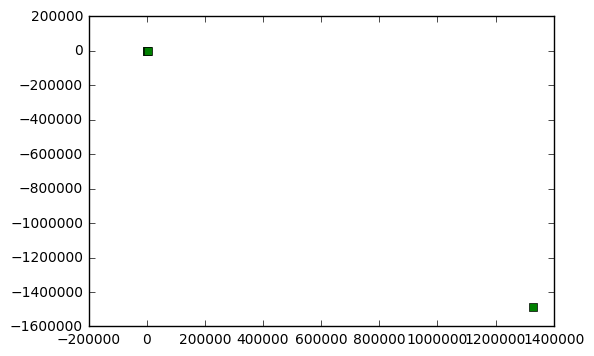

In [22]:
plot(data, target, mu)

In [23]:
weights = initial_weights
mu = initial_mu
segma = initial_segma
a, b, out = forward(data, initial_weights, initial_mu, initial_segma)
print out
print target
print cost(target, out)

dEdW, dEdMu, dEdSegma = update_parameters(data, target, weights, mu, segma)
print dEdMu
print dEdW
print dEdSegma

weights -=  dEdW
mu -= stepsize_mu * dEdMu
segma -= stepsize_segma * dEdSegma

print weights
print mu
print segma

[[-0.00229866]
 [-0.00194194]
 [-0.00202984]
 [-0.00206249]
 [-0.00161349]
 [-0.00071885]
 [-0.00182846]
 [-0.00076003]
 [-0.00123693]
 [-0.00073154]
 [-0.00120789]
 [-0.00075139]
 [-0.00100896]
 [-0.00101964]
 [-0.00058983]
 [-0.0003636 ]
 [-0.00075599]
 [-0.00031195]
 [-0.00045501]
 [-0.00035289]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
5.00683320593
[[  8.29336507e-03  -2.18859507e-03]
 [  6.59561543e-03  -9.39358694e-03]
 [ -1.27958066e-01   3.56971199e-02]
 [ -3.43650959e+02   3.84108610e+02]]
[[ -5.65717383e-05]
 [ -2.67981154e-12]
 [  0.00000000e+00]
 [  0.00000000e+00]]
[  2.11864085e-03   2.08629121e-10   0.00000000e+00  -0.00000000e+00]
[[-121.0719544 ]
 [-121.38681186]
 [-118.21873117]
 [  -6.03196555]]
[[ -3.60833682e+02   9.54375681e+01]
 [ -3.86367554e+02   5.53627810e+02]
 [  2.73098371e+03  -7.61621146e+02]
 [  1.32810802e+06  -1.48446220e+06]]
[ 77.4901692   89.89292735